# Deep Learning with Python
# 6.4.0 - Advanced RNNs

Will be using three different techniques to improve RNN performance on a **sequence regression** task - predicting the temperature using past values of temperature, pressure, wind, and other climate data.

These techniques are
1. Recurrent Dropout - a specific, built-in way to use dropout to fight overfitting in recurrent layers.
2. Stacking recurrent layers - increases the representational power of the network (albeit at the cost of higher computational complexity).
3. Bidirectional recurrent layers - present same information to recurrent network in different ways, increasing accuracy and mitigating overfitting.

## Loading Temperature Data
Reading dataset with sensor readings for temperature, pressure, humidity, wind speed, etc. from 2009 - 2016. Assumes the data is stored in a CSV file in the same directory as the notebook.

In [33]:
import os

In [34]:
data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [35]:
# Open the file and read the data 
f = open(fname)
data = f.read()
f.close()

In [36]:
# Every row in the data starts on a newline - split to create list of rows
lines = data.split('\n')

In [37]:
# First row in list of rows is header, with column names separated by ','
header = lines[0].split(',')

In [38]:
# The actual data is stored in all other lines
lines = lines[1:]

In [39]:
# Sanity check - what does the header look like? How many rows of data?
print("Column names/attributes:\n", header)
print("The number of rows is: ", len(data))

Column names/attributes:
 ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
The number of rows is:  43164220


In [40]:
# Converting all rows to numpy arrays that can be fed to a neural network
import numpy as np

In [41]:
# Can't just cast data to float - must split each row into list of comma-separated values
# And then cast each value to a float. Assign this value to the right element in np array of zeros
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # 0th is row number
    float_data[i, :] = values

## Plotting Sample Data
Plotting the `numpy` values for temperature for all timesteps to verify data has been read correctly.

In [42]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Temperature (2009 - 2016)')

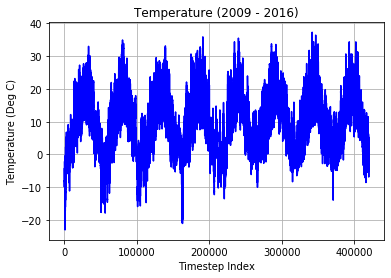

In [43]:
temp = float_data[:, 1] # Temperature values are in degrees Celsius
plt.plot(range(len(temp)), temp, 'blue')
plt.grid(True);
plt.xlabel('Timestep Index')
plt.ylabel('Temperature (Deg C)')
plt.title('Temperature (2009 - 2016)')

There is a clear periodicity in the temperature values across all indices, where each index represents a timestep in the time sereis data. We can also see that temperature, on average, has been increasing.

In [44]:
# Can also explore the first 10 days of temperature data
periodicity_of_recording = 10 # Minutes
minutes_in_day = 24 * 60
total_days = 10
total_data_points = (total_days * minutes_in_day) / periodicity_of_recording
print(f"Total data points for {total_days}: {total_data_points}")

Total data points for 10: 1440.0


Text(0.5, 1.0, 'Temperature (First 10 days)')

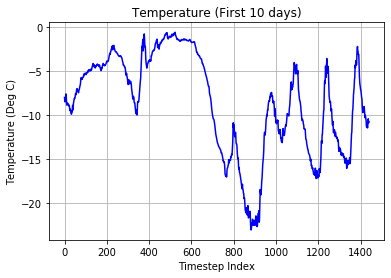

In [45]:
plt.plot(range(int(total_data_points)), temp[:int(total_data_points)], 
        'blue')
plt.xlabel('Timestep Index')
plt.ylabel('Temperature (Deg C)')
plt.grid(True)
plt.title('Temperature (First 10 days)')

The temperature data over the first ten days is not as periodic as the data over the entire 2009 - 2016 period. However, there is a clear pattern of rising and falling temperature towards the end of this interval.

Also, temperature values are much lower in the first 10 days, indicating this data is from a relatively cold winter month.

## Formulating the Problem
Given data that goes as far back as `lookback` timesteps with data that is sampled every `steps` timesteps, can the temperature after `delay` timesteps be predicted? 

For this problem, we're defining the following values for three params: `lookback`, `steps`, and `delay`.

### `lookback`
This is the number of past timesteps that will be used to make predictions. We've set its value to 720. Since there are 144 timesteps in a day, this means we we will be using $\frac{720}{144} = 5$ days worth of data to make predictions.

### `steps`
The number of observations that will be sampled at one data point per hour. One observation is made every 10 minutes. This means in 60 minutes or one hour, 6 observations will be made. How to reconcile this with **observations sampled at one data point per hour**?

### `delay`
The number of timesteps into the future for which we will have to make predictions. We've set its value to 144, which means we will be making predictions $\frac{144}{144} = 1$ day into the future.

In [30]:
float_data.shape

(420551, 14)

## Preprocessing

Don't need to convert data format because it has already been cast to numpy floats. 

Will still need to normalize values because different features will take different ranges of values.

In [46]:
# Find the mean temperature of each timeseries independently. axis = 0 means row
mean = float_data[:200000].mean(axis=0)

# Subtract the mean from each reading in the timeserie
float_data -= mean

# Calculate the standard deviation of each timeseries independently
std = float_data[:200000].std(axis=0)

Also creating a generator that will yield tuples `(samples, targets` where `samples` is a single batch of input data and `targets` is the corresponding array of target temperatures.

Because there will be a lot of redundancy between successiive batches, input batches should be generated on the fly with a generator. This saves memory. 

In [68]:
def generator(data, lookback, delay, min_index, max_index, 
             shuffle=False, batch_size=128, step=6):
    """Generates batches of data samples and their predicted temperatures"""
    if max_index is None:
        # If max_index not specified, equal to the last index that has a future temperature available
        max_index = len(data) - delay - 1
    
    # Start processing at the current minimum index with offset for `lookback` samples
    i = min_index + lookback

    # Will continue to generate batches of samples indefinitely
    while 1:
        if shuffle:
            # Create a batch of random indices between the first index with at `lookback` samples
            # and maximum index
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                # reset current index if indices exceed the max index for the dataset
                i = min_index + lookback
            
            # Sequential series of indices from `i` to either `batch_size` or `max_index` - whichever doesn't exceed max
            rows = np.arange(i, min(i + batch_size, max_index))
            
            # Once these rows have been processed, increment the batch marker
            i += len(rows)
            
            # Create array to store samples for the current batch
            samples = np.zeros((len(rows),                  # Batch axis
                               lookback // steps,           # Number of sampled timesteps 
                               data.shape[-1]))             # At each timestep, record all features
            
            # Create np array of targets
            targets = np.zeros((len(rows), ))
            
            # Parse all rows in the dataset
            for j, row in enumerate(rows):
                # indices from the last lookback rows to the current rows in steps
                indices = range(rows[j] -  lookback, rows[j], step)
                
                # Index dataset to get data for this sample
                samples[j] = data[indices]
                
                # Get the temperature columns value for the current row after delay
                targets[j] = data[rows[j] + delay][1]

            # Return the samples and targets - yield because this is a generator
            yield samples, targets

Using the `generator` function to instantiate three generators for training, validation, and testing.

Each will look at different subsets of the training data to generate batches of data.

The first 200,000 timesteps will be used to generate batches for training, the next 100,000 timesteps will be used for validation, and the remainder will be used for testing.

## Preparing Generators

In [69]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [70]:
train_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=0, 
                     max_index=200000, 
                     shuffle=True, 
                     step=step, 
                     batch_size=batch_size)

In [71]:
val_gen = generator(float_data, 
                   lookback=lookback, 
                   delay=delay,
                   min_index=200001, 
                   max_index=300000,
                   batch_size=batch_size)

In [72]:
test_gen = generator(float_data, 
                   lookback=lookback, 
                   delay=delay, 
                   min_index=300001, 
                   max_index=None, 
                   step=step,
                   batch_size=batch_size)

In [73]:
# How many steps or batches to draw from `val_gen` to see entire validation set?
val_steps = (300000 - 200001 - lookback)

# How many steps or batches to draw from `test_gen` in ordr to see the entire test set?
test_steps = (len(float_data) - 300001 - lookback)

## Establishing A Baseline 
Temperature values are continuous and periodic: temperature value today is likely to be near the temperature today. Thus, a baseline error we will have to beat is the MAE achieved when we always predict tomorrow's temperature to be today's temperature.

In [74]:
def evaluate_naive_method():
    """Establishes baseline MAE for temperature prediction by 
    predicting tomorrow's temperature to be the same as today's temperature"""
    batch_maes = []
    for step in range(val_steps):
        # Get the next batch of samples and their future temperature values 
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.nean(batch_maes))